In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 10 - Explore Interest Rate / Term Interaction - Model Simplification
Scripts numbered "1X" explore the discrepancy between interactions measured by ALE and SHAP. 

 In this script, I show that the discrepant ALE and SHAP behavior is more reliably reproduced for more complex models.  I use tuning parameters from the base model, and create simplified models, including:
  - Reduce number of features
  - Reduce max depth
  - Reduce tree count

I examine the SHAP and ALE curves for these simplified models.  Generally, the behavior is most easily seen for models with 4+ features and sufficient depths.  Increased tree count also helps.

*This script takes about 20 minutes to run on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle, importlib
from IPython.display import Image

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
import shap

In [6]:
from PyALE import ale

In [7]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

In [8]:
importlib.reload(ip_plot)

<module 'interactions_package.interactions_package.ip_plot' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/code/interactions_package/interactions_package/ip_plot.py'>

## Import data

##### Training data

In [9]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [10]:
train_df.shape

(874451, 35)

In [11]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

In [12]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv')) \
    ['feature'].tolist()

##### Iniital model

In [13]:
# Initial model
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

In [14]:
fit_params_base = base_model.get_params()
fit_params_base

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### Important features

In [15]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

In [16]:
perm_importance_df.head(5)

,features,importance,abs_importance
0,int_rate,0.001057,0.001057
1,term,0.000776,0.000776
2,home_ownership__RENT,0.000478,0.000478
3,loan_amnt,0.000418,0.000418
4,mort_acc,0.000253,0.000253


## Functions for Model Simplification
Create models and see if we observe opposite interaction effects for ALE and Shapley for the interest rate and term interactions.  Fit a model, and evaluate SHAP and ALE values.  Fit on a full training data set, evaluate on a sample

##### Fit a model, and get ALE and SHAP values

In [17]:
def model_fit_ale_shap(train_data, eval_data, features, fit_params, 
                   target_feature = 'target',
                   interaction_features = ['int_rate', 'term'],
                   high_int_thresh = 20,
                   random_state=888):
    
    # Get the model
    model = GradientBoostingClassifier(n_estimators = fit_params['n_estimators'],
                                       random_state=random_state)
    model.set_params(**fit_params)
    model.fit(train_data[features], train_data[target_feature])
    
    # Get the ALE data for interest rate and term
    this_ale = ale(X=eval_data[features], model=model, 
                   feature=interaction_features, 
                   plot=False)
    
    # Get SHAP information
    explainer = shap.TreeExplainer(model, feature_names=features)
    shap_interactions =  explainer.shap_interaction_values(eval_data[features])
    
    # Get SHAP for only the interaction of interest
    term_ind = features.index(interaction_features[1])
    int_rate_ind = features.index(interaction_features[0])
    this_shap = pd.concat([eval_data[interaction_features].reset_index(drop=True),
                            pd.DataFrame({'shap': shap_interactions[:,term_ind, int_rate_ind]})],
                           axis=1)
    
    return model, this_ale, this_shap
    

##### Call the above function, with saving, also plot and get linear fit information

In [18]:
def get_analyze_reduced_model(train_data, eval_data, features, fit_params, 
                              target_feature = 'target',
                              interaction_features = ['int_rate', 'term'],
                              random_state=111,
                              outdir = None,
                              outfile_prefix = None,
                              plot_title = None):
    
    # Get the model, and ALE/SHAP info
    model, ale_df, shap_df = model_fit_ale_shap(train_data, eval_data, features, fit_params, 
                                                target_feature, interaction_features, random_state)
    
    # Create the SHAP and ALE plot
    fig = ip_plot.plot_comp_ale_shap(ale_df, shap_df, title=plot_title)
    
    # Do a linear fit to see if the SHAP/ALE have different trends
    lin_fit = ip_plot.comb_ale_shap_lin_reg_info(ale_df, shap_df, flatten_data = True,
                                                feature_names = interaction_features)
         
    # Save data and plots if applicable
    if outdir is not None:
        with open(outdir.joinpath(outfile_prefix + '_model.pkl'), 'wb') as po:
            pickle.dump(model, po)
        ale_df.columns = ale_df.columns.astype(str)
        ale_df.to_parquet(outdir.joinpath(outfile_prefix + '_ale.parquet'))
        shap_df.to_parquet(outdir.joinpath(outfile_prefix + '_shap.parquet'))
        fig.savefig(outdir.joinpath(outfile_prefix + '_plot.png'), bbox_inches='tight')
        lin_fit.columns = lin_fit.columns.astype(str)
        lin_fit.to_csv(outdir.joinpath(outfile_prefix + '_lin_fit.csv'), index=False)
    plt.close()
        
    # Return summary information
    return lin_fit
    

## Feature Reduction
Start with the top 10 features and reduce from there.

##### Create sub-directory to hold numerous plots

In [19]:
plot_red_folder = Path(setup.temp_path) \
    .joinpath('10_PLOT_FEAT_REDUCE')
plot_red_folder.mkdir(parents=True, exist_ok=True)

##### Reduce features in a loop and save summary information

In [20]:
%%capture
num_feat = [10, 8, 6, 4, 3, 2]
out_res = pd.DataFrame()
for n in num_feat:
    this_feat_list = perm_importance_df['features'].head(n).to_list()
    this_prefix = f'{n:02}'
    red_mod_res = get_analyze_reduced_model(train_df, train_samp_df, 
                                            this_feat_list, fit_params_base,
                                            outdir = plot_red_folder,
                                            outfile_prefix=this_prefix,
                                            plot_title = f'Top {n} Features')
    red_mod_res['n'] = n
    red_mod_res['prefix'] = this_prefix
    out_res = pd.concat([out_res, red_mod_res], axis=0)

In [21]:
out_res.to_csv(Path(setup.temp_path).joinpath('10_REPORT_feature_reduction_loop.csv'), index=False)
out_res

,coef_0_36_ale,coef_0_36_shap,interecept_36_ale,interecept_36_shap,mean_value_36_ale,mean_value_36_shap,coef_0_60_ale,coef_0_60_shap,interecept_60_ale,interecept_60_shap,mean_value_60_ale,mean_value_60_shap,n,prefix
0,-0.002697,-0.005114,0.034103,0.067860,-0.051629,-0.015249,0.002697,-0.010288,-0.034103,0.134105,0.051629,-0.109028,10,10
0,-0.002827,-0.005148,0.035742,0.068151,-0.054144,-0.013686,0.002827,-0.010208,-0.035742,0.134504,0.054144,-0.107520,8,08
0,-0.003042,-0.005383,0.038460,0.073443,-0.058261,-0.014304,0.003042,-0.007977,-0.038460,0.106655,0.058261,-0.089259,6,06
0,-0.004006,-0.005103,0.050659,0.071006,-0.076740,-0.008761,0.004006,-0.007692,-0.050659,0.099396,0.076740,-0.091380,4,04
0,-0.005186,-0.006731,0.065575,0.093267,-0.099336,-0.037101,0.005186,-0.006489,-0.065575,0.081485,0.099336,-0.074302,3,03
0,0.000000,-0.006485,0.000000,0.092243,0.000000,-0.032418,0.000000,-0.005389,0.000000,0.063587,0.000000,-0.065763,2,02


##### Show the plots

2


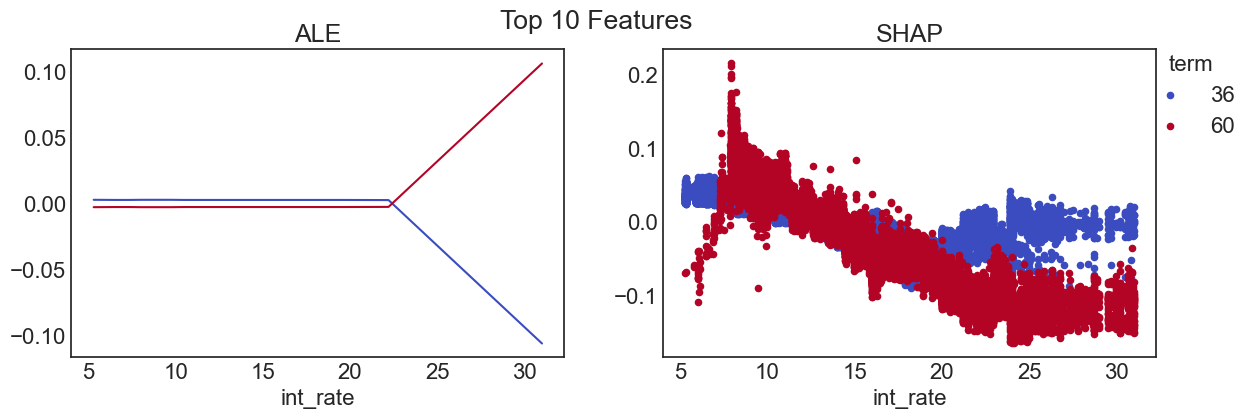

2


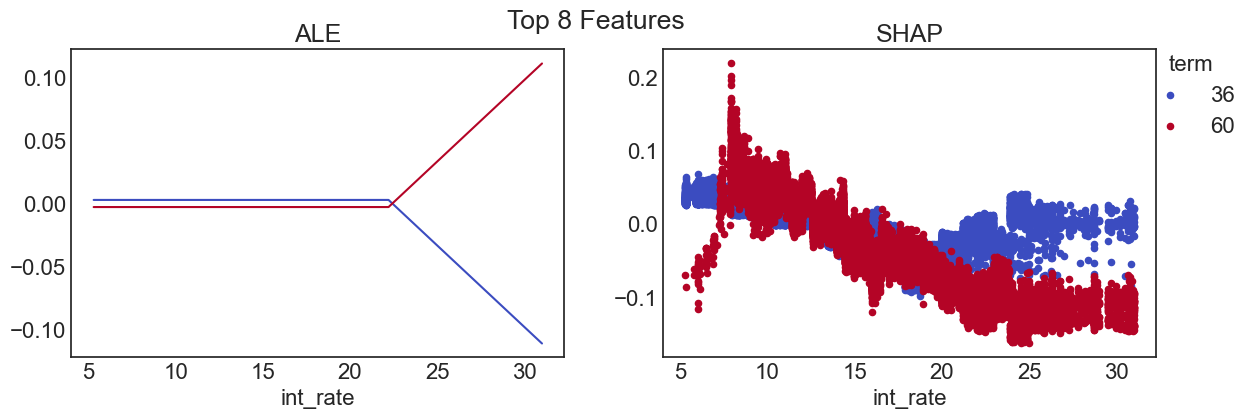

2


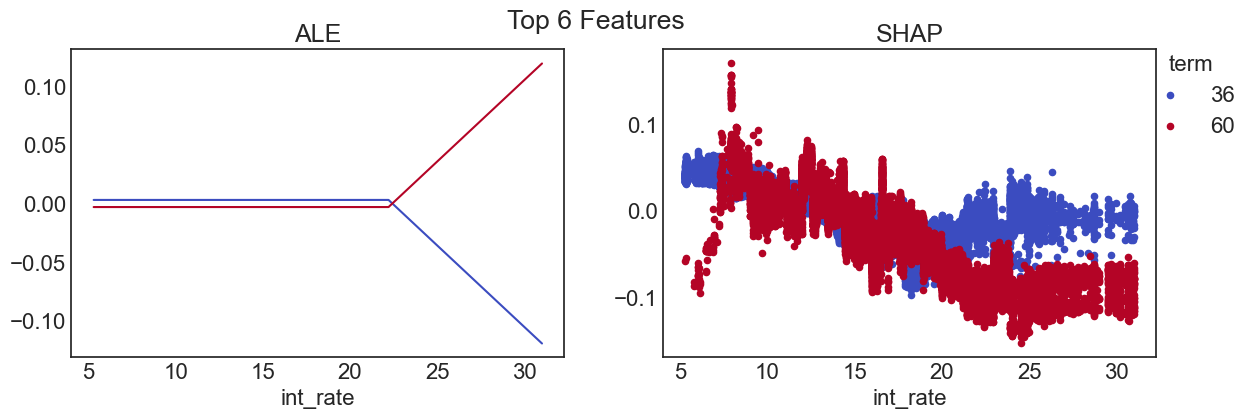

2


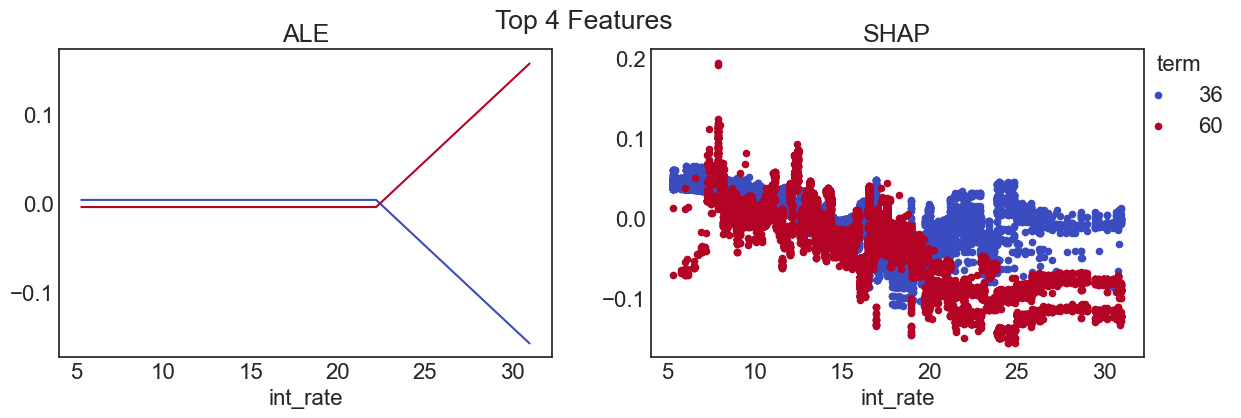

2


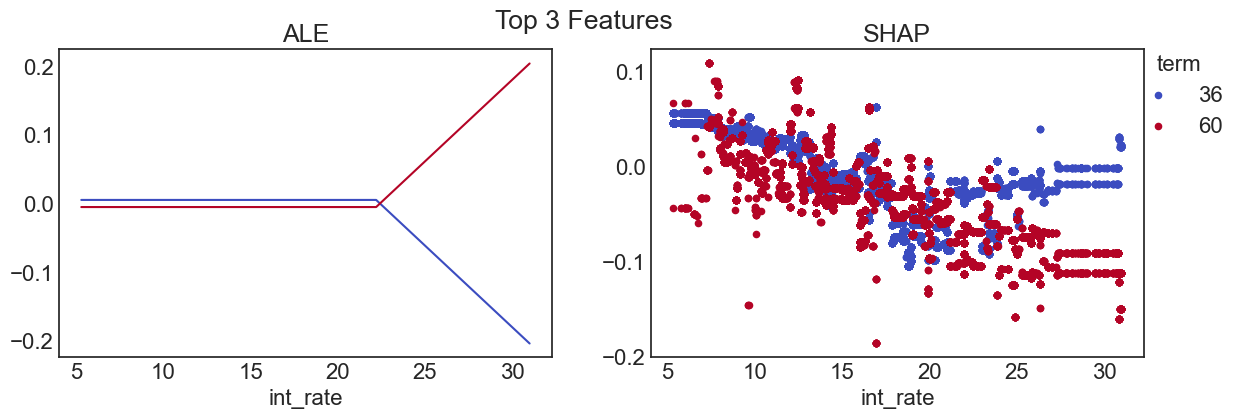

2


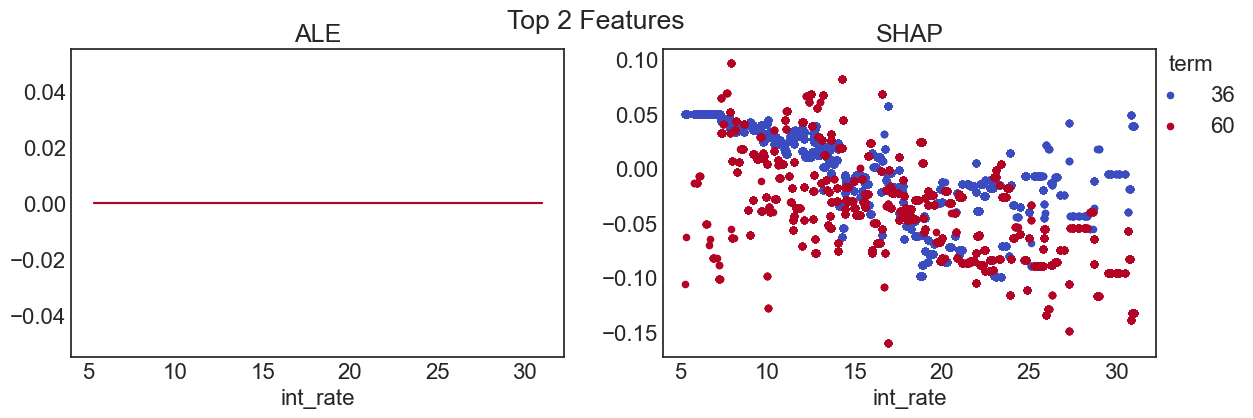

In [22]:
for prefix in out_res['prefix'].to_list():
    print(n)
    display(Image(filename = plot_red_folder.joinpath(f'{prefix}_plot.png')))

Even with a set random seed, results of the fits may not be deterministic.  

The SHAP plots always seem to show their usual general behavior (overlapping curves at low interest rates, then the red 60 month curve keeps decreasing while the blue 36 month curve levels off or increases).

The ALE plots can vary quite a bit run-to-run. Generally, 4+ feature runs show the same discrepant behavior as full runs. The 2 and 3 feature curves can vary.

For me, the 2-feature curve never shows the discrepant behavior.  SHAP is always flat, or ALE has the same trend as SHAP. (Look closely at the plot - whether the blue or red lines are on top)

Sometimes the 3-feature plot shows the discrepant behavior but sometimes ALE and SHAP agree.  Once you get to 4+ features, I generally see the opposing trends in ALE vs. SHAP

The point of divergence seems to be at lower interest rates above 4 features, with the ALE curves showing interactions above maybe 17%.  With fewer features, the point of divergence is more like 22%

## Reduced-Feature Model - Vary Depth
Here, I attempt to change the complexity of a reduced feature model, reducing the tree depth

I use the large-ish number of trees for all models, as I observe that often not all trees show the behavior, and I want to pull out a single simplified tree.  I may get a better simplified tree if I try a lot of trees.

##### Create a folder to hold multiple plots / datasets

In [23]:
n_feat = 5
plot_nfeat_depth_folder = Path(setup.temp_path) \
    .joinpath('10_PLOT_N_FEATURES_MAX_DEPTH')
plot_nfeat_depth_folder.mkdir(parents=True, exist_ok=True)

In [24]:
#top_feat = perm_importance_df['features'].head(n_feat).to_list()
top_feat = ['int_rate', 'term', 'annual_inc']
top_feat

['int_rate', 'term', 'annual_inc']

##### Loop to explore different tree depths

In [25]:
%%capture
max_depth = [6, 5, 4, 3]

out_res_depth = pd.DataFrame()
for m in max_depth:
    this_prefix = f'{m:02}'
    this_params = fit_params_base.copy()
    this_params['max_depth'] = m
    red_mod_res = get_analyze_reduced_model(train_df, train_samp_df, 
                                            top_feat, this_params,
                                            outdir = plot_nfeat_depth_folder,
                                            outfile_prefix=this_prefix,
                                            plot_title = f'Max Depth {m}',
                                           random_state=911)
    red_mod_res['max_depth'] = m
    red_mod_res['n_features'] = n_feat
    red_mod_res['prefix'] = this_prefix
    out_res_depth = pd.concat([out_res_depth, red_mod_res], axis=0)

In [26]:
out_res_depth.to_csv(Path(setup.temp_path).joinpath('10_REPORT_max_depth_loop.csv'), index=False)
out_res_depth

,coef_0_36_ale,coef_0_36_shap,interecept_36_ale,interecept_36_shap,mean_value_36_ale,mean_value_36_shap,coef_0_60_ale,coef_0_60_shap,interecept_60_ale,interecept_60_shap,mean_value_60_ale,mean_value_60_shap,max_depth,n_features,prefix
0,-0.002384,-0.006929,0.030149,0.095478,-0.045671,-0.044391,0.002384,-0.006409,-0.030149,0.084589,0.045671,-0.070327,6,5,06
0,-0.002382,-0.006928,0.030117,0.094997,-0.045623,-0.040598,0.002382,-0.005813,-0.030117,0.082594,0.045623,-0.060504,5,5,05
0,0.000000,-0.006722,0.000000,0.089513,0.000000,-0.034421,0.000000,-0.006391,0.000000,0.098159,0.000000,-0.063705,4,5,04
0,0.000000,-0.005286,0.000000,0.070929,0.000000,-0.027580,0.000000,-0.003750,0.000000,0.054392,0.000000,-0.043835,3,5,03


##### Show the plots

2


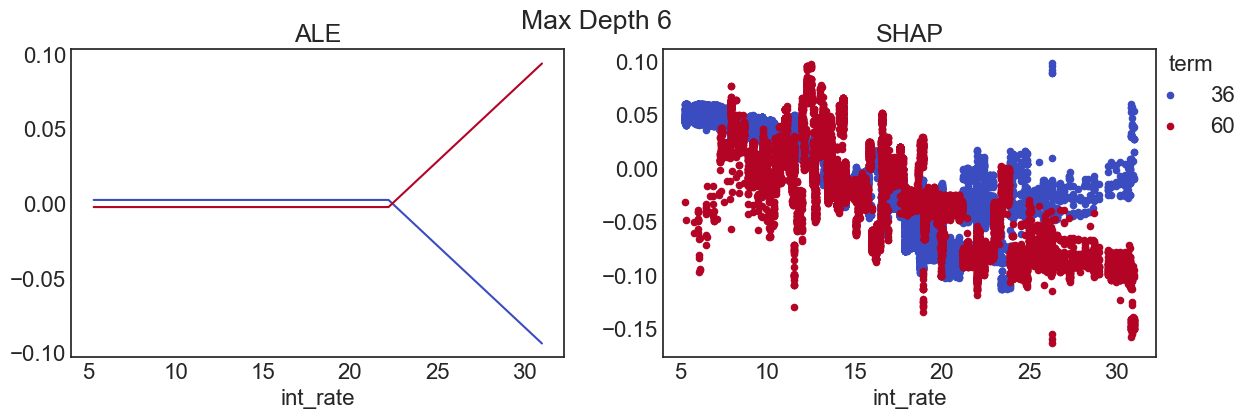

2


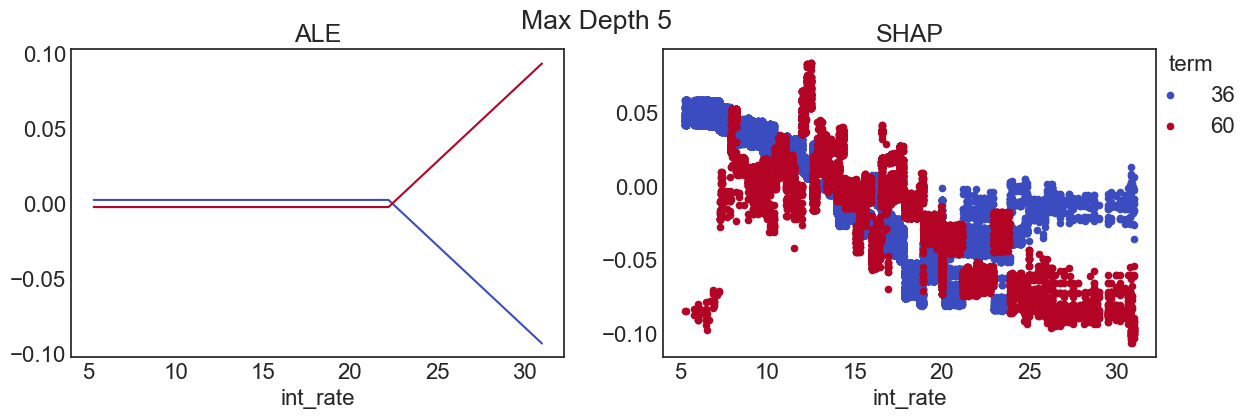

2


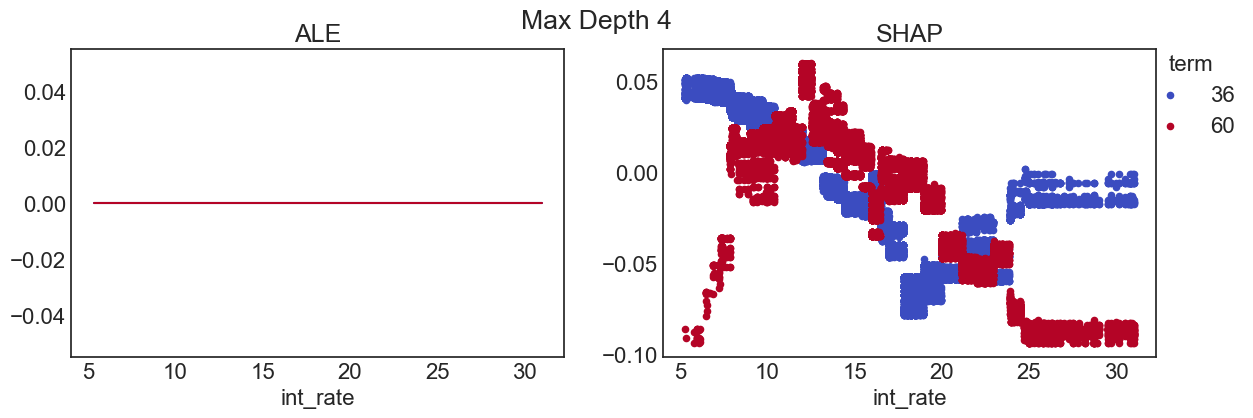

2


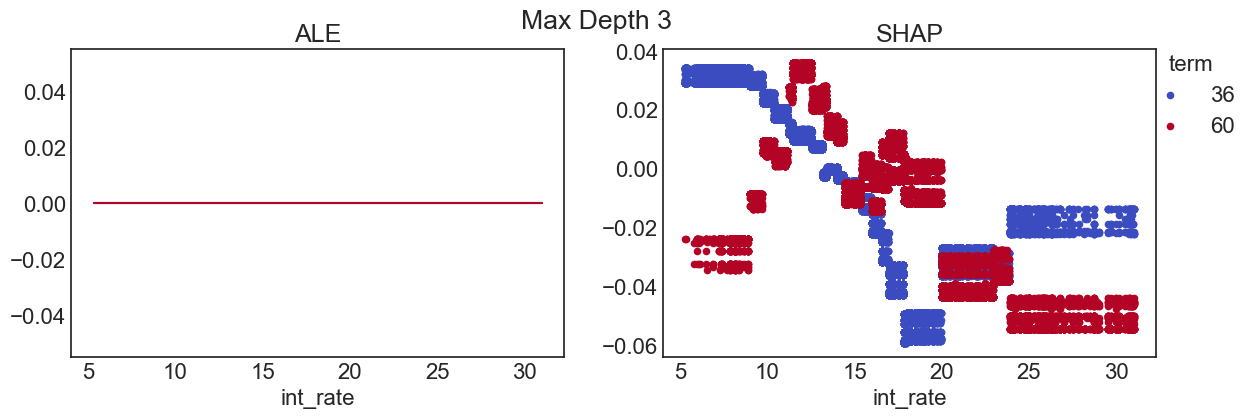

In [27]:
for prefix in out_res_depth['prefix'].to_list():
    print(n)
    display(Image(filename = plot_nfeat_depth_folder.joinpath(f'{prefix}_plot.png')))

For me, max depth 5 and above show the discrepant behavior.  The lower tree depths show steps in the SHAP plots, which may be expected, and some differences at low interest rate.  Results are not deterministic, but more complex models seem to more often show the discrepant behavior.

## Few-Feature Model - Vary Tree Count
Here, I attempt to change the complexity of a reduced feature model, fixing the depth and reducing tree count

##### Create a folder to hold multiple plots / datasets

In [28]:
plot_nfeat_tree_folder = Path(setup.temp_path) \
    .joinpath('10_PLOT_N_FEATURES_TREE_RED')
plot_nfeat_tree_folder.mkdir(parents=True, exist_ok=True)

##### Loop to explore different estimator counts

In [29]:
%%capture
n_est = [20, 18, 13, 10, 5, 1]

out_res_n_est = pd.DataFrame()
for n in n_est:
    this_prefix = f'{n:02}'
    this_params = fit_params_base.copy()
    this_params['n_estimators'] = n
    red_mod_res = get_analyze_reduced_model(train_df, train_samp_df, 
                                            top_feat, this_params,
                                            outdir = plot_nfeat_tree_folder,
                                            outfile_prefix=this_prefix,
                                            plot_title = f'Tree Count {n}',
                                           random_state=42)
    red_mod_res['n_estimators'] = n
    red_mod_res['prefix'] = this_prefix
    red_mod_res['n_features'] = n_feat
    out_res_n_est = pd.concat([out_res_n_est, red_mod_res], axis=0)

In [30]:
out_res_n_est.to_csv(Path(setup.temp_path).joinpath('10_REPORT_tree_count_loop.csv'), index=False)
out_res_n_est

,coef_0_36_ale,coef_0_36_shap,interecept_36_ale,interecept_36_shap,mean_value_36_ale,mean_value_36_shap,coef_0_60_ale,coef_0_60_shap,interecept_60_ale,interecept_60_shap,mean_value_60_ale,mean_value_60_shap,n_estimators,prefix,n_features
0,-0.002384,-0.006929,0.030149,0.095478,-0.045671,-0.044391,0.002384,-0.006409,-0.030149,0.084588,0.045671,-0.070327,20,20,5
0,-0.002362,-0.006744,0.029864,0.092977,-0.045240,-0.043911,0.002362,-0.006193,-0.029864,0.081997,0.045240,-0.067469,18,18,5
0,0.000000,-0.006216,0.000000,0.085827,0.000000,-0.041317,0.000000,-0.004937,0.000000,0.069425,0.000000,-0.051001,13,13,5
0,0.000000,-0.005578,0.000000,0.077232,0.000000,-0.035306,0.000000,-0.004223,0.000000,0.059216,0.000000,-0.043515,10,10,5
0,0.000000,-0.003938,0.000000,0.054163,0.000000,-0.023441,0.000000,-0.002232,0.000000,0.033298,0.000000,-0.024133,5,05,5
0,0.000000,-0.001135,0.000000,0.015490,0.000000,-0.007553,0.000000,-0.000437,0.000000,0.006752,0.000000,-0.005509,1,01,5


##### Show the plots

1


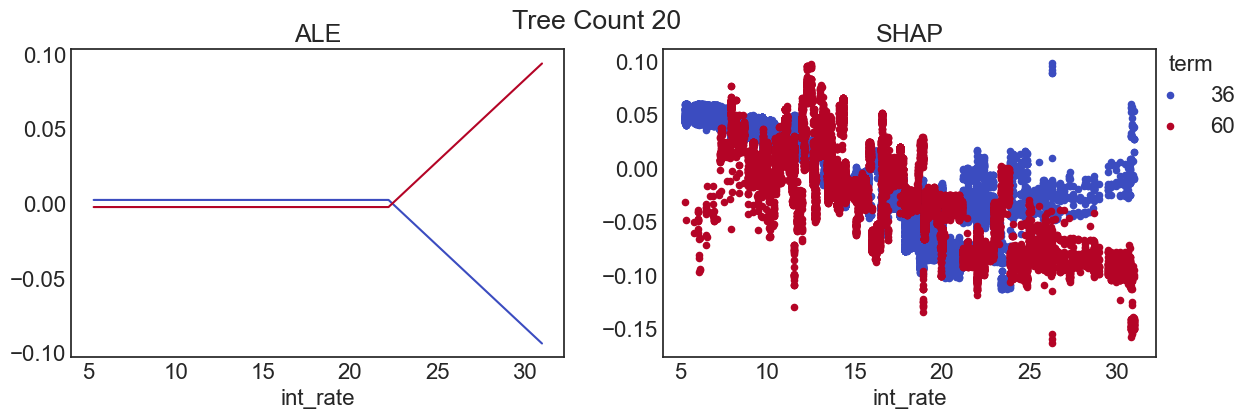

1


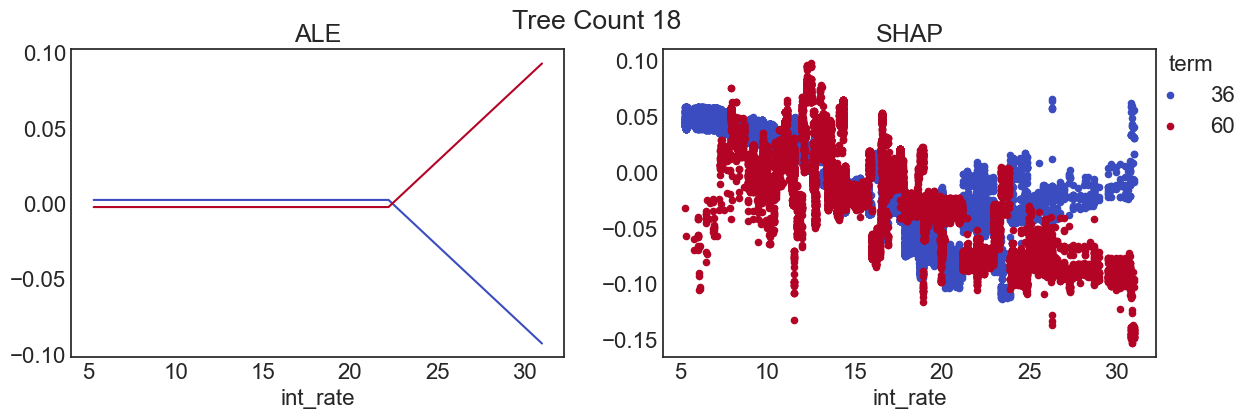

1


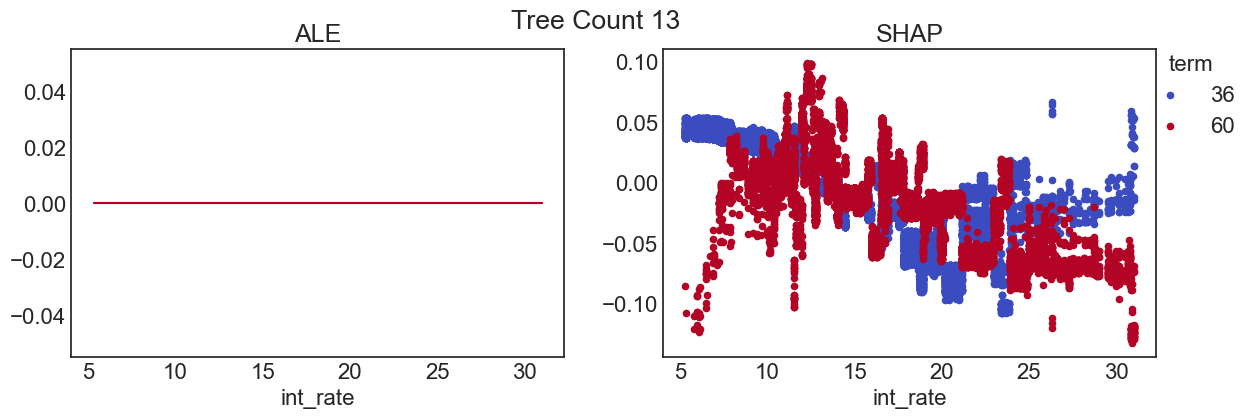

1


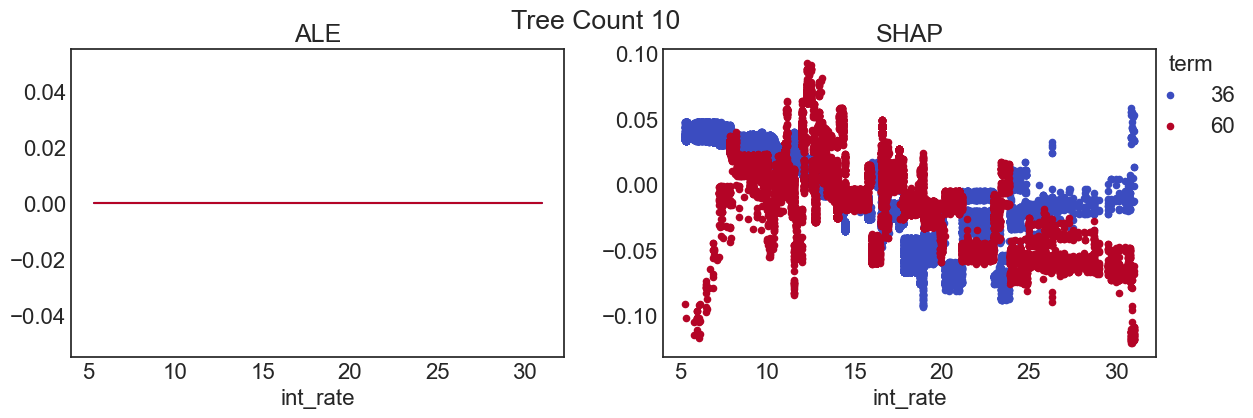

1


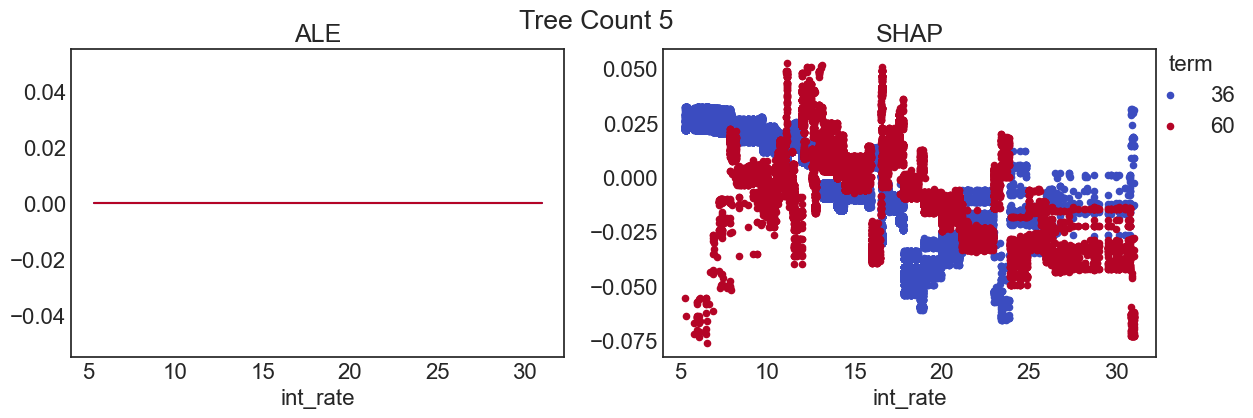

1


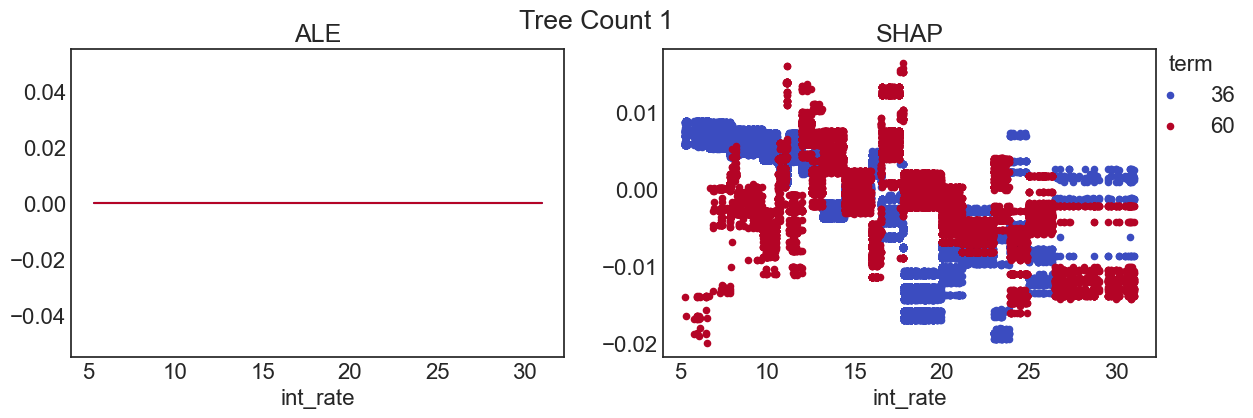

In [31]:
for prefix in out_res_n_est['prefix'].to_list():
    print(n)
    display(Image(filename = plot_nfeat_tree_folder.joinpath(f'{prefix}_plot.png')))

Increased tree count appears to make the behavior more likely

## Conclusions

More complex models show the behavior, and it isn't easy to fit a single tree that can be analyzed to understand the discrepancy

Through a lot of trial and error, I did find such a tree which I will examine next.